In [21]:
import numpy as np 
import cauchy_estimator as ce 
import gaussian_filters as gf
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('TkAgg',force=True) 

Welcome to tutorial 2! Here we will go over how to set-up the PyCauchyEstimator and PySlidingWindowManager classes to estimate the state of a nonlinear dynamic system. If you have not already taken a look over the tutorial lti_systems.ipynb, now would be a very good time to do so. This tutorial introduced both these classes, and some conventions that will likely be glossed over in this tutorial. 

Setting up the Cauchy Estimator for nonlinear systems is just as straight forward as running an Extended Kalman filter. Lets take a simple 2-state nonlinear system and set-up the EKF for it. Then, we will go ahead and set-up the Cauchy Estimator. In the spirit of historically significant but simple systems, lets consider a simple swinging pendulum example, illustrated below:
![title](imgs/pendulum.jpg)


The pendulum is a nonlinear system with two states of interest: the angle $\theta$ from its stationary vertical position, and its angular rate $\dot{\theta}$. Pulling out our old high school physics textbook, the equation of motion (EOM) for angular acceleration $\ddot{\theta}$ is given as
\begin{equation}
    \ddot{\theta} = -\frac{g}{L} \text{sin}(\theta) - c\dot{\theta} + w
\end{equation}
where $g$ is the acceleration due to gravity, $L$ is the length of the pendulum, c is a damping factor which will reduce the amplitude of the penduulum swing, and w is a zero mean process noise with power spectral density $W$, which could either model the imperfect identification of the $c$ parameter, or possibly some squeakiness on the hinge of the pendulum. We can simulate this system nicely using really any integration method with the above EOM. Here, we'll use an RK4 integrator, since its already baked into the cauchy_estimator module. Let's go ahead and simulate the pendulum motion of $\theta$ and $\dot\theta$ starting at an angle of $45$ degrees:

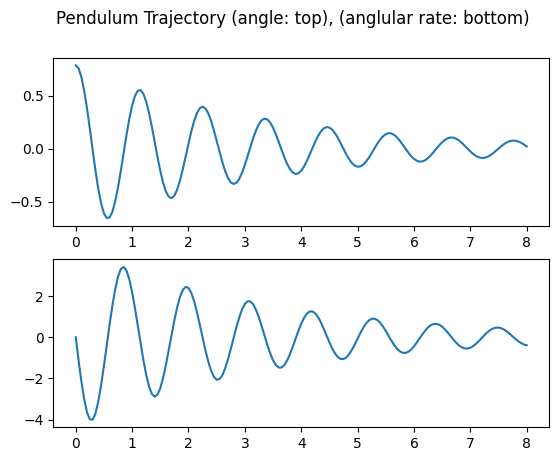

In [22]:
class PendulumParams:
    L = 0.3 # meters
    g = 9.81 # meters / second^2
    c = 0.6 # 1/seconds (damping)
    w_PSD = 0.01 # power spectral density of c-time process noise
    dt = 0.05 # integration step time

pend = PendulumParams() # Lets just make a simple globally viewable object to get ahold of these parameters when we want them

# The ODE
def pend_ode(x):
    dx_dt = np.zeros(2)
    dx_dt[0] = x[1]
    dx_dt[1] = -pend.g / pend.L * np.sin(x[0]) - pend.c * x[1]
    return dx_dt 

# Nonlinear transition model from t_k to t_k+1...ie: dt
def nonlin_transition_model(x):
    return ce.runge_kutta4(pend_ode, x, pend.dt)

theta_vec0 = np.array([np.pi/4, 0]) # initial angle of 45 degrees at 0 radians/sec
theta_k = theta_vec0.copy()
thetas = [theta_k]
propagations = 160
for k in range(propagations):
    theta_k = nonlin_transition_model(theta_k)
    thetas.append(theta_k)
thetas = np.array(thetas)
Ts = np.arange(propagations+1) * pend.dt
plt.figure()
plt.suptitle("Pendulum Trajectory (angle: top), (anglular rate: bottom)")
plt.subplot(211)
plt.plot(Ts, thetas[:, 0])
plt.subplot(212)
plt.plot(Ts, thetas[:, 1])
plt.show()

Looks like the simulation works fine. Now, lets create some angle measurements. Physically, this could be done using some sort of encoder on the rotational hinge of the pendulum, or with some type of distance sensor setup. Regardless, well observe $\theta_k$, noisily. Lets add a bit of process noise (imperfection) in its swing. For now, lets assume all noises are Gaussian. So far, our system and measurements are essentially:
\begin{align}
    x &= \begin{bmatrix}\theta\\\dot\theta\end{bmatrix}\\
    \dot{x} &= f(x) + \Gamma_c w, \quad \Gamma_c = \begin{bmatrix}0\\1\end{bmatrix}\\ 
    z_k &= [1, 0] x_k + v_k
\end{align}

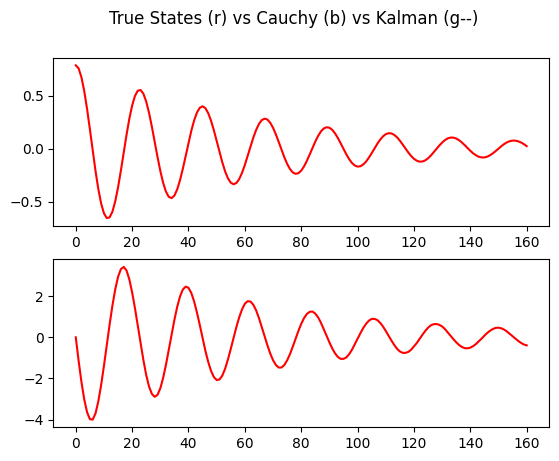

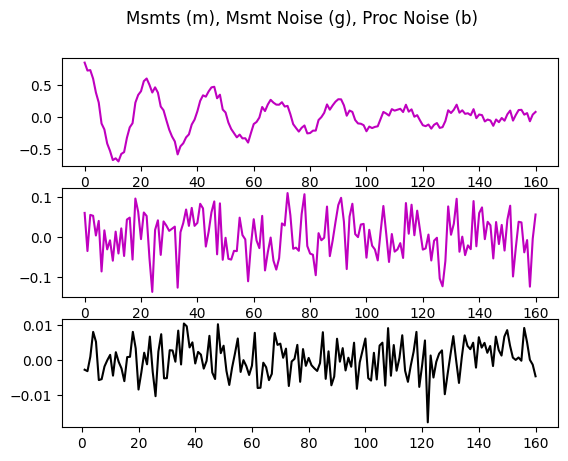

In [23]:
# Creating the dynamic simulation
V = np.array([[0.003]]) # measurement noise on theta
H = np.array([1.0,0.0]) # meausrement model
xk = theta_vec0.copy()
xs = [xk] # State vector history
ws = []   # Process noise history
vs = [V[0]**0.5 * np.random.randn()] # Measurement noise history
zs = [H @ xk + vs[0]] # Measurement history
propagations = 160
for k in range(propagations):
    wk = pend.dt * pend.w_PSD**0.5 * np.random.randn(1)
    xk[1] += wk
    xk = nonlin_transition_model(xk)
    xs.append(xk)
    ws.append(wk)
    vk = V[0]**0.5 * np.random.randn(1)
    zk = H @ xk + vk
    vs.append(vk)
    zs.append(zk)
xs = np.array(xs)
zs = np.array(zs)
ws = np.array(ws)
vs = np.array(vs)
ce.plot_simulation_history(None, (xs,zs,ws,vs), None)
# Now we have our simulation data!

Looks good. We cheated a bit by adding the process noise to the angular rate state before passing it through the dynamics, but it saves extra effort and makes a minimal impact. Besides, if an estimator can't handle slight imperfections between its model and reality, it's really no good anyhow! 

Lets now create an EKF to track the states. The EKF, like the KF is ubiquitous, and it's real simple. We can directly use the RK4 propagator above since the EKF allows you to nonlinearly propagate the state estimate. We'll model the state transition matrix $\Phi_k$ and process noise matrix $W_k$ for the EKF as follows:

\begin{align}
    \Phi_k &\approx \sum_{i=0}^{L}\frac{\left(\nabla_x{f}(x)\right)^i\Delta^i}{i!}\\
    W_k = \int_{t_k}^{t_{k+1}} \Phi_k \Gamma_c W \Gamma_c^T \Phi_k^T d\tau \approx & \int_{0}^{\Delta} \left(\sum_{i=0}^{L}\frac{\left(\nabla_x{f}(x)\right)^i\tau^i}{i!}\right) \Gamma_c W \Gamma_c^T \left(\sum_{j=0}^{L}\frac{\left(\nabla_x{f}(x)\right)^j\tau^j}{j!}\right)^T d\tau \\
    =&  \sum_{i=0}^{L} \sum_{j=0}^{L} \left(\nabla_x{f}(x)\right)^i \Gamma_c W \Gamma_c^T \left(\nabla_x{f}(x)\right)^{jT} \frac{\Delta^{i+j+1}}{i+j+1}
\end{align}
where $L$ is the taylor order, $\Delta = t_{k+1}-t_k$ is the time increment, and $\left(\nabla_x{f}(x)\right)^i$ is the matrix power of the jacobian matrix of the nonlinear dynamics. That is, well compute $\Phi_k$ using a taylor series expansion, and we'll be (extra) kind to the EKF and use a very good approximation of the discrete time process noise that enters the system over the time step $\Delta$. There are many ways to discretize process noise for a nonlinear system. But, since these routines are already baked into the cauchy_estimator module, they'll do the trick. Let's setup the EKF, and give it some modest uncertainty about the angle and angular velocity with which the pendulum begins swinging:

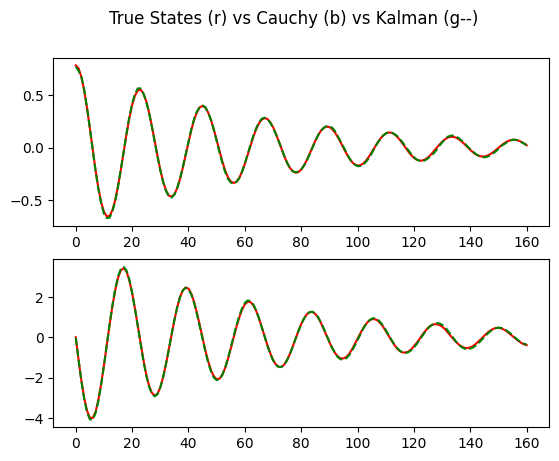

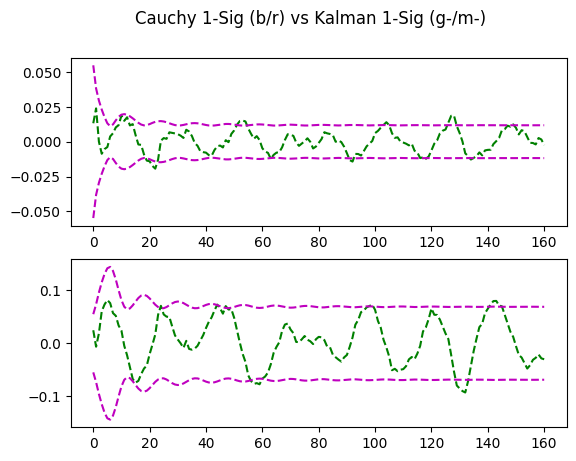

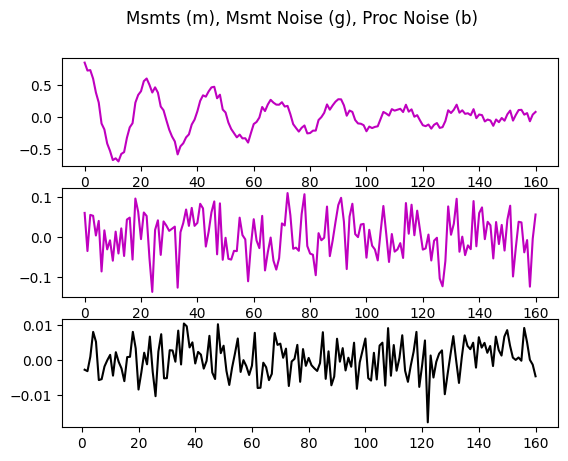

In [24]:
def jacobian_pendulum_ode(x):
    Jac = np.zeros((2,2))
    Jac[0,1] = 1
    Jac[1,0] = -pend.g/pend.L*np.cos(x[0])
    Jac[1,1] = -pend.c
    return Jac

# Continuous time Gamma (\Gamma_c)
Gamma_c = np.array([[0.0,1.0]]).T
W_c = np.array([[pend.w_PSD]])
I2 = np.eye(2)
H = H.reshape((1,2))
taylor_order = 2

# Setting up and running the EKF
# The gaussian_filters module has a "run_ekf" function baked in, but we'll just show the whole thing here
P0_kf = np.eye(2) * 0.003
x0_kf = np.random.multivariate_normal(theta_vec0, P0_kf) # lets initialize the Kalman filter slightly off from the true state position

xs_kf = [x0_kf.copy()] 
Ps_kf = [P0_kf.copy()] 
x_kf = x0_kf.copy()
P_kf = P0_kf.copy() 
for k in range(propagations):
    Jac_F = jacobian_pendulum_ode(x_kf)
    Phi_k, W_k = ce.discretize_nl_sys(Jac_F, Gamma_c, W_c, pend.dt, taylor_order, with_Gamk = False, with_Wk = True)
    # Propagate covariance and state estimates
    P_kf = Phi_k @ P_kf @ Phi_k.T + W_k
    x_kf = nonlin_transition_model(x_kf)
    # Form Kalman Gain, update estimate and covariance
    K = P_kf @ H.T @ np.linalg.inv(H @ P_kf @ H.T + V)
    zbar = H @ x_kf
    r = zs[k+1] - zbar
    x_kf += K @ r 
    P_kf = (I2 - K @ H) @ P_kf @ (I2 - K @ H).T + K @ V @ K.T
    # Store estimates
    xs_kf.append(x_kf.copy())
    Ps_kf.append(P_kf.copy())
xs_kf = np.array(xs_kf)
Ps_kf = np.array(Ps_kf)
# Plot Simulation results 
ce.plot_simulation_history( None, (xs,zs,ws,vs), (xs_kf, Ps_kf) )

The EKF tracks both states well! Onto bigger and better things. Let's go ahead and setup the Cauchy Estimator for this nonlinear system. We'll approach it in the following way. First, we will go ahead and introduce how to setup callbacks for the nonlinear system, since the Cauchy Estimator for nonlinear systems requires these. Then, we will run a single estimator (PyCauchyEstimator) a few steps and make sure everything looks good. Then, we'll go ahead and setup the estimator for the full simulation using the PySlidingWindowManager class.

For nonlinear systems, we need to write three callback functions for the estimator

1.) A callback function which: 

$\bullet$ Propagates the state estimate from $k-1$ to $k$, i.e, $\bar{x}_k = f(x_{k-1}, u_{k-1})$ (Just like the EKF, this can be done nonlinearly)

$\bullet$ Sets the state transition matrix $\Phi_k$

$\bullet$ Sets the process noise gain matrix $\Gamma_k \in \mathbb{R}^{n\times r}$

$\bullet$ (Re)sets the process noise scale paramater vector $\beta_k \in \mathbb{R}_{++}^{r}$, if its time-varying.

2.) A callback function which takes the current state estimate and hypothesizes what the measurement should be: i.e, $\bar{z}_k = h(\bar{x}_k)$ 

3.) A callback function which takes the current state estimate and forms $H_k \in \mathbb{R}^{p\times n}$, and (re)sets the measurement noise scale paramater $\gamma_k \in \mathbb{R}_{++}^{p}$, if its time-varying.

    
As a preliminary to the above, a quick tangent is in order. Since we are supplying the underlying C-code with Python-based callback functions, we need an intermediate data structure that can be used to move arrays from C, into Numpy arrays for you to manipulate, and then back to C. Internally, the C-side Cauchy Estimator uses a structure called CauchyDynamicsUpdateContainer, which holds pointers to the dynamics/noise statistics, which are used in the internal sub-routines. This structure maintains $\{x_k,u_k,\Phi_k,\Gamma_k,B_k,H_k,\beta_k,\gamma_k,\Delta,k\}$ in C. All of these matrix/vector containers are available to you through get/set methods using the Py_CauchyDynamicsUpdateContainer class. The following shows how the base callback mechanism from C to Python (and then back to C) works:

In [25]:
# This is the callback function correpsonding to the decription for point 1.) above 
def foobar_dynamics_update(c_duc):
    pyduc = ce.Py_CauchyDynamicsUpdateContainer(c_duc)
    ## Propagate x 
    #x = pyduc.cget_x()
    #u = pyduc.cget_u()
    #xbar <- f(x,u)
    #pyduc.cset_x(xbar)
    #pyduc.cset_is_xbar_set_for_ece() # need to call this!
    ## Phi, Gamma, beta may update
    #pyduc.cset_Phi(Phi)
    #pyduc.cset_Gamma(Gamma)
    #pyduc.cset_beta(beta)

# This is the callback function correpsonding to the decription for point 2.) above 
def foobar_nonlinear_msmt_model(c_duc, c_zbar):
    pyduc = ce.Py_CauchyDynamicsUpdateContainer(c_duc)
    ## Set zbar
    #x = pyduc.cget_x() # xbar
    #zbar = msmt_model(x)
    #pyduc.cset_zbar(c_zbar, zbar)

# This is the callback function correpsonding to the decription for point 3.) above 
def foobar_msmt_model_jacobian(c_duc):
    pyduc = ce.Py_CauchyDynamicsUpdateContainer(c_duc)
    ## H and gamma may update
    #x = pyduc.cget_x() # xbar
    # H <- jacobian( h(x) )
    #pyduc.cset_H(H)
    #pyduc.cset_gamma(gamma)

Lets go through the psuedo code above. When the estimator needs the user to update the dynamics/noise statistics, the C-Code sends Python a pointer (i.e, c_duc) to the CauchyDynamicsUpdateContainer structure, which maintains all the dynamics arrays (on the C-side). Simply put, the call 'pyduc = ce.Py_CauchyDynamicsUpdateContainer(c_duc)' then transforms this pointer to a python usable object (internally with some nifty help via c-types). As the psuedo functions above imply, the "pyduc.cget_" calls returns you a numpy array for the queried matrix/vector. You are then free to do what you please with it. Then, the "pyduc.cset_" calls return the data to the underlying C-program. 

Two important notes should be made for the psuedo functions above:

$\bullet$ Note that after calling "pyduc.cset_x(xbar)" in your "dynamics_update" callback function, you must call pyduc.cset_is_xbar_set_for_ece(). This is because the developer of the Cauchy Estimator (i.e, the author of these tutorials :-) ) was very worried about users forgetting to send the time propagated state $\bar{x}_k$ back to C. The program will raise an assertion error and exit, if this is not done. 

$\bullet$ Note that c_zbar in the "nonlinear_msmt_model" callback is a pointer to $\bar{z}_k$ on the C-side, once you compute $\bar{z}_k$ in your callback, use "pyduc.cset_zbar(c_zbar, zbar)" to safely set c_zbar.

Now that we have the flavor of how the callbacks work, lets go ahead and setup the Cauchy Estimator for this nonlinear system. We'll start by setting up the PyCauchyEstimator for a few time steps to make sure everything is okay. A quick reminder from the lti_systems tutorial is that we will setup the discrete time dynamics for the Cauchy Estimator as:
\begin{align}
    \Phi_k &\approx \sum_{i=0}^{L}\frac{\left(\nabla_x{f}(x)\right)^i\Delta^i}{i!}\\
    \Gamma_k &= \int_{t_k}^{t_{k+1}}\Phi_k\Gamma_c d\tau \approx \int_{0}^{\Delta} \sum_{i=0}^{L}\frac{\left(\nabla_x{f}(x)\right)^i\tau^i}{i!}\Gamma_c d\tau\\
    &=  \sum_{i=0}^{L}\frac{\left(\nabla_x{f}(x)\right)^i\Delta^{i+1}}{i+1!}\Gamma_c\\
    W_k &= \frac{W}{\Delta}
\end{align}


Let's get onto the code. Lets run the nonlinear estimator a few time steps to make sure everything is OK and we have no bugs:

In [26]:
# This is the callback function correpsonding to the decription for point 1.) above 
def dynamics_update(c_duc):
    pyduc = ce.Py_CauchyDynamicsUpdateContainer(c_duc)
    ## Propagate x 
    xk = pyduc.cget_x()
    xbar = nonlin_transition_model(xk) # propagate from k -> k+1
    pyduc.cset_x(xbar)
    pyduc.cset_is_xbar_set_for_ece() # need to call this!
    ## Phi, Gamma, beta may update
    Jac_F = jacobian_pendulum_ode(xk)
    Phi_k, Gam_k = ce.discretize_nl_sys(Jac_F, Gamma_c, None, pend.dt, taylor_order, with_Gamk=True, with_Wk=False)
    pyduc.cset_Phi(Phi_k)
    pyduc.cset_Gamma(Gam_k)
    #pyduc.cset_beta(beta)

# This is the callback function correpsonding to the decription for point 2.) above 
def nonlinear_msmt_model(c_duc, c_zbar):
    pyduc = ce.Py_CauchyDynamicsUpdateContainer(c_duc)
    ## Set zbar
    xbar = pyduc.cget_x() # xbar
    zbar = H @ xbar # for other systems, call your nonlinear h(x) function
    pyduc.cset_zbar(c_zbar, zbar)

# This is the callback function correpsonding to the decription for point 3.) above 
def msmt_model_jacobian(c_duc):
    pyduc = ce.Py_CauchyDynamicsUpdateContainer(c_duc)
    ## Set H: for other systems, call your nonlinear jacobian function H(x)
    pyduc.cset_H(H) # we could write some if condition to only set this once, but its such a trivial overhead, who cares

scale_g2c = 1.0 / 1.3898 # scale factor to fit the cauchy to the gaussian
beta = np.array([pend.w_PSD / pend.dt])**0.5 * scale_g2c
gamma = np.array([V[0,0]**0.5]) * scale_g2c
x0_ce = x0_kf.copy()
A0 = np.eye(2)
p0 = np.diag(P0_kf)**0.5 * scale_g2c 
b0 = np.zeros(2)
steps = 5
num_controls = 0
print_debug = True
cauchyEst = ce.PyCauchyEstimator("nonlin", steps, print_debug)
cauchyEst.initialize_nonlin(x0_ce, A0, p0, b0, beta, gamma, dynamics_update, nonlinear_msmt_model, msmt_model_jacobian, num_controls, pend.dt)
cauchyEst.step(zs[0])
cauchyEst.step(zs[1])
cauchyEst.step(zs[2])
cauchyEst.step(zs[3])
cauchyEst.step(zs[4])
cauchyEst.shutdown()

Set Cauchy Estimator Mode to: nonlin
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 5 time-steps, 1 measurements per step == 5 total times!
Moment Information (after MU) at step 1, MU 1/1 (took 0 ms)
fz: 2.1531642616451072 + 0.0000000000000000j
Conditional Mean:
0.0368769695907438 + 0.0000000000000000j, 0.0000000000000000 + 0.0394101710681513j, 
Conditional Variance:
0.0029130724698176 + 0.0000000000000000j, 0.0000000000000000 + 0.0000000000000000j, 
0.0000000000000000 + 0.0000000000000000j, 0.0000000000000000 + 0.0000000000000000j, 

Moment Information (after FTR) at step 1, MU 1/1 (took 0 ms)
fz: 1.0000000000000000 + 0.0000000000000000j
Conditional Mean:
0.0368769695907438 + -0.0000000000000000j, 0.0000000000000000 + 0.0394101710681513j, 
Conditional Variance:
0.0029130724698176 + -0.0000000000000000j, 0.0000000000000000 + 0.0000000000000000j, 
-0.0000000000000000 + 0.0000000000000000

The results are error free. It is good practice to make sure a single estimator is running cleanly for a few steps, before moving onto to the PySlidingWindowManager for a full simulation. You can place break points inside the callback functions to pause and poke around the "pyduc" object created within the callbacks, if you are running this notebook interactively with a debugger. One thing to note is that unlike the LTI simulations in the last tutorial, for nonlinear systems, we supply the initial state estimate $x_0$...and set the median vector $b_0$ to zero. Truth be told, this was a poor design choice on the developers part (sorry), as only one of these arguments really is needed and the class constructor is somewhat over-parameterized. However, the rule of thumb is to set $b_0$ to the zero vector and supply the intial system state hypothesis $x_0$.


My last tangent, I promise:

If we examine the output of the first estimation step, something interesting has happened, which is that only the first state has a non-zero mean and variance. The second state, (while it shows zero), is actually undefined. The reason is due to $A_0$ being set to the identity matrix $I$ to begin, and $H=[1,0]$. Theoretically, what has happened is we told the estimator that initially the (Cauchy distributed) states are uncoupled ($A_0=I$), and we are only observing the first state. Therefore, the second state's moments remain undefined (ie, they remain completely "Cauchy"!). Next, we time propagate and process another measurement. Now, the states have coupled information, and both states have defined moments. If we had coupled the states together, say, with $A_0 = \Phi_0^T$ to begin, both the conditional mean and covariance would be defined. You can try this for yourself.

The rule of thumb here is that, if the resultant matrix/vector product $A_0H^T \in \mathbb{R}^{n\times p}$ has all zero elements across any row (or very close to all zeros), the state corresponding to this row index (or indices) will not have moments at the intial step. At the next time (after a time propagation), however, the states will now be coupled (so long as $\Phi_k$ is a full rank matrix) and all moments will exist, no issue. 

However, a bigger issue (which doesn't happen in this simulation) can arise if the matrix/vector product of $H_k\Gamma_k \in \mathbb{R}^{p\times r}$ (depending on the resultant dimensions) has any zero elements. It is a little more niche than how I'll leave it here, but generally, the estimator will not produce moments (at least not for some states). If $H$ and $\Gamma$ are constants, and the previous condition is seen, the estimator will never produce moments (at least not for some states). This is entirely due to the Cauchy modelling assumption. We are telling the system that we are driving a Cauchy process noise $w_k$ into the system, via $\Gamma_k w_k$, since $w_k$ has undefined mean and variance (i.e, it could be any real number since its Cauchy!), but have no way of observing it via $H_k$. It could now be anywhere! It is almost elegant that it wouldn't produce moments, as it makes perfect theoretical sense. Make sure you set up your system dynamics to get around this, if you can. In this simulation, we have nothing to worry about, and almost always, this condition isn't seen. $\Gamma_k$ will, almost always, have all non-zero enteries.

Tangent complete, but it's a pretty neat detail, right? Let's setup the PySlidingWindowManager and visualize the results of the EKF and the Cauchy Estimator for this Gaussian noise simulation:

Set Sliding Window Manager Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You ca

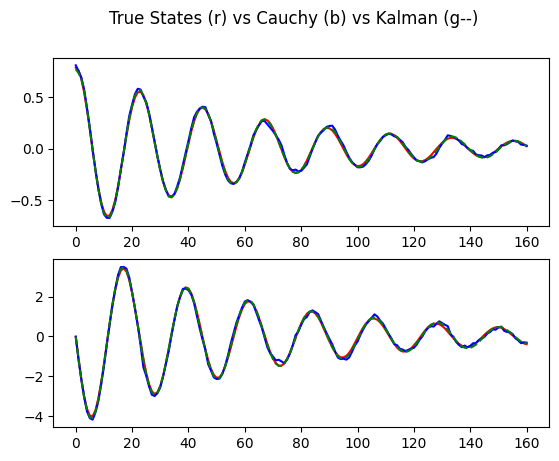

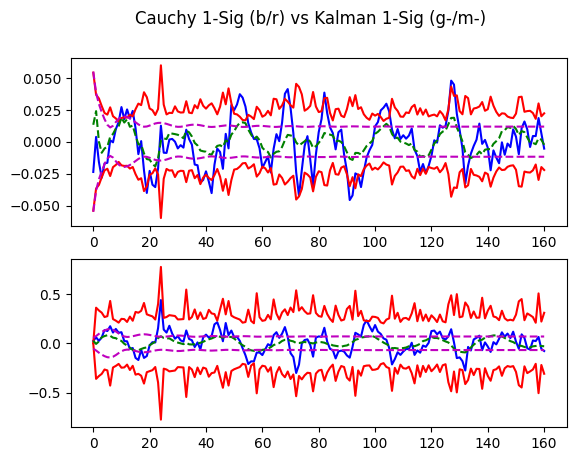

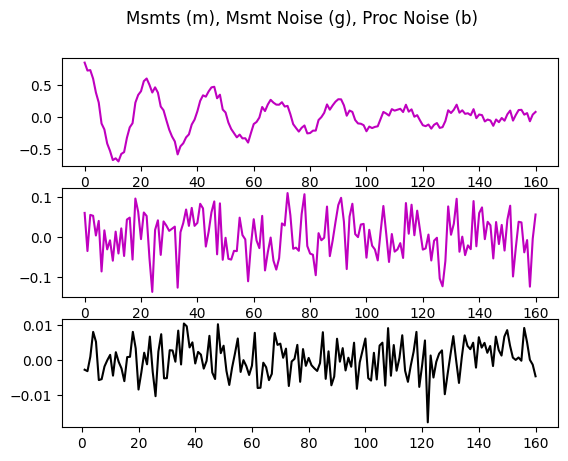

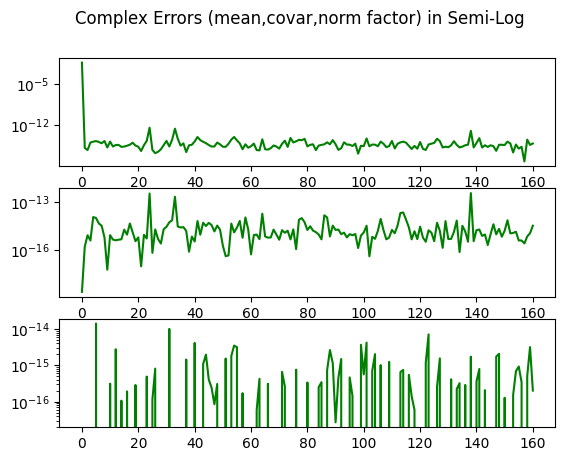

In [27]:
swm_print_debug = False 
win_print_debug = False
num_windows = 6
cauchyEst = ce.PySlidingWindowManager("nonlin", num_windows, swm_print_debug, win_print_debug)
cauchyEst.initialize_nonlin(x0_ce, A0, p0, b0, beta, gamma, dynamics_update, nonlinear_msmt_model, msmt_model_jacobian, num_controls, pend.dt)
for zk in zs:
    cauchyEst.step(zk, None)
cauchyEst.shutdown()

ce.plot_simulation_history( cauchyEst.moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf) )
#ce.plot_simulation_history( cauchyEst.avg_moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf) )

We can see that the Cauchy Estimator is a bit pessimistic in its estimates, as its 1-sigma bounds are fairly larger than the EKFs for both states. This can happen when H does not include coefficients touching all states. The estimation results are good, nevertheless, but since we are in Gaussian noise, a very simple fix is to tune the process noise statistic down slightly for the estimator, until the Cauchy 1-sigma bounds hugs that of the EKF:

Set Sliding Window Manager Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You ca

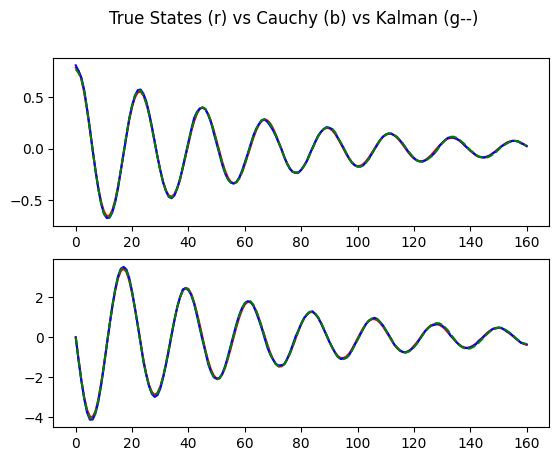

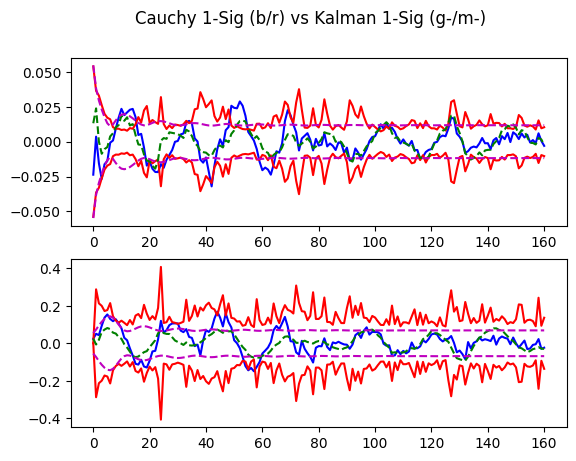

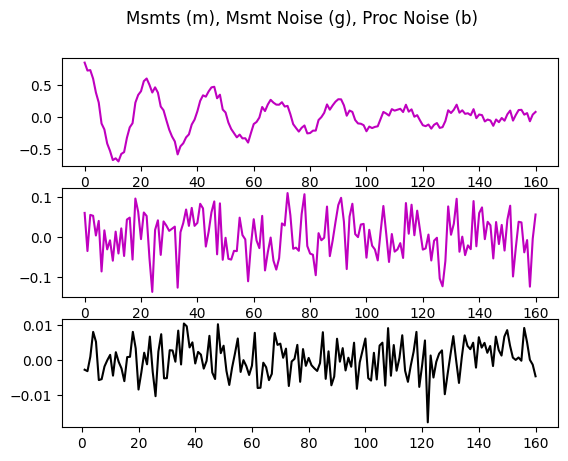

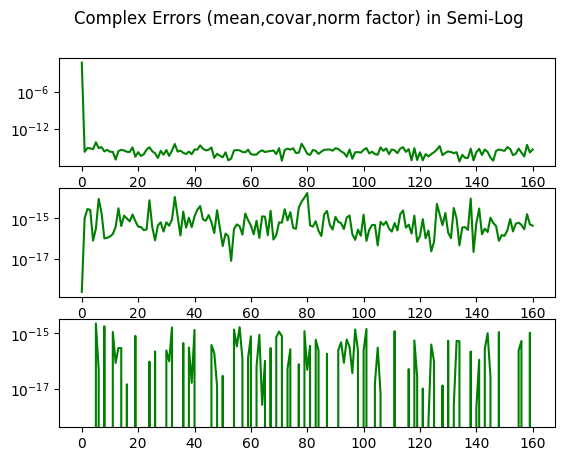

In [28]:
swm_print_debug = False 
win_print_debug = False
num_windows = 6
_beta = beta / 5 # tuned down
cauchyEst = ce.PySlidingWindowManager("nonlin", num_windows, swm_print_debug, win_print_debug)
cauchyEst.initialize_nonlin(x0_ce, A0, p0, b0, _beta, gamma, dynamics_update, nonlinear_msmt_model, msmt_model_jacobian, num_controls, pend.dt)
for zk in zs:
    cauchyEst.step(zk, None)
cauchyEst.shutdown()

ce.plot_simulation_history( cauchyEst.moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf) )
#ce.plot_simulation_history( cauchyEst.avg_moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf) )

Now... the Cauchy Estimator looks nearly identical to the EKF. It is kind of amazing how the Cauchy Estimator is essentially a Kalman filter in Gaussian noise. Now, you have the knowledge to run any kind of linear or nonlinear simulation with this package!

To conclude, lets have a little estimation fun. Suppose that the true damping coefficient of the pendulum increases significantly about a quarter way into the simulation. That is, the damping coefficient is piece wise. However, neither estimator is privy to this change in the underlying dynamics, and will continue to use the nominal dynamics. What will happen? (erhm...hint hint).

Set Sliding Window Manager Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 10 time-steps, 1 measurements per step == 10 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 10 time-steps, 1 measurements per step == 10 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 10 time-steps, 1 measuremen

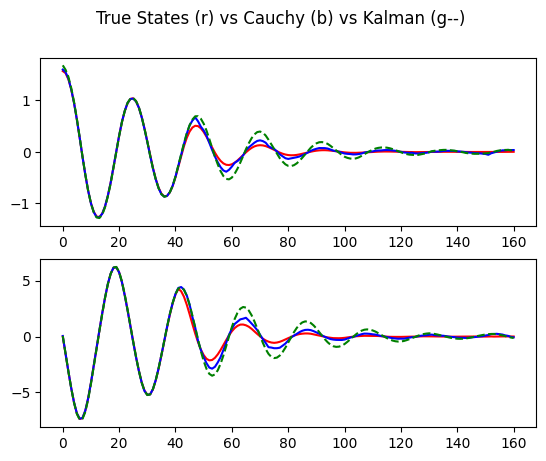

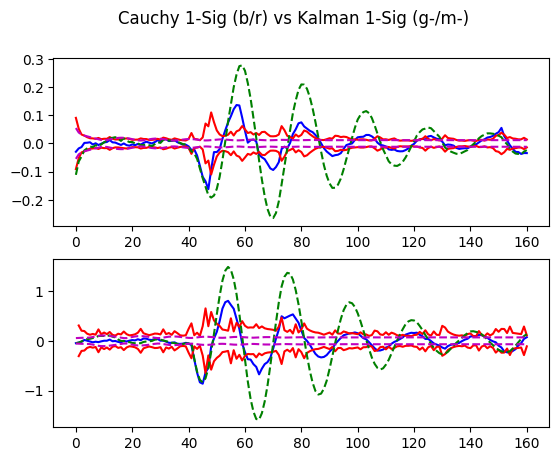

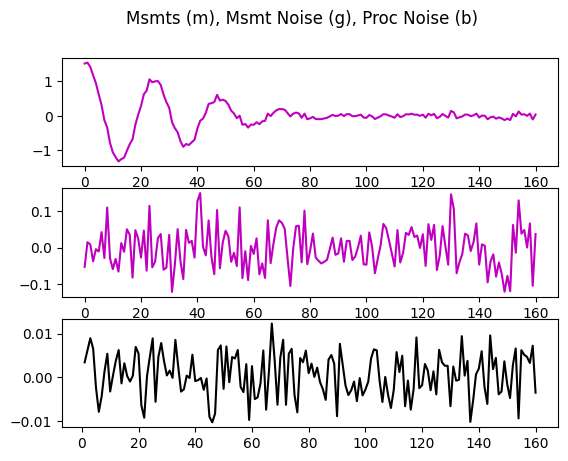

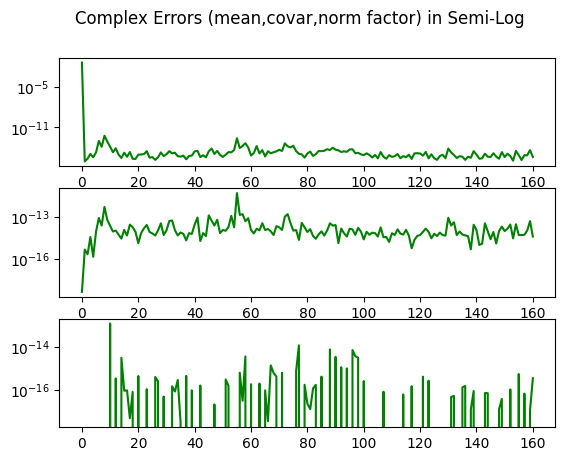

In [32]:
theta0 = 2*theta_vec0
# Creating the dynamic simulation
xk = theta0.copy()
xs = [xk] # State vector history
ws = []   # Process noise history
vs = [V[0]**0.5 * np.random.randn()] # Measurement noise history
zs = [H @ xk + vs[0]] # Measurement history
propagations = 160
c0 = pend.c
for k in range(propagations):
    wk = pend.dt * pend.w_PSD**0.5 * np.random.randn(1)
    xk[1] += wk
    xk = nonlin_transition_model(xk)
    xs.append(xk)
    ws.append(wk)
    vk = V[0]**0.5 * np.random.randn(1)
    zk = H @ xk + vk
    vs.append(vk)
    zs.append(zk)
    if k == 40:
        pend.c = c0 * 4 #* 0.25 # all of a sudden, the pendulum changes its damping greatly
pend.c = c0
xs = np.array(xs)
zs = np.array(zs)
ws = np.array(ws)
vs = np.array(vs)

# Setting up and running the EKF
x0_kf = np.random.multivariate_normal(theta0, P0_kf) # lets initialize the Kalman filter slightly off from the true state position

xs_kf = [x0_kf.copy()] 
Ps_kf = [P0_kf.copy()] 
x_kf = x0_kf.copy()
P_kf = P0_kf.copy() 
for k in range(propagations):
    Jac_F = jacobian_pendulum_ode(x_kf)
    Phi_k, W_k = ce.discretize_nl_sys(Jac_F, Gamma_c, W_c, pend.dt, taylor_order, with_Gamk = False, with_Wk = True)
    # Propagate covariance and state estimates
    P_kf = Phi_k @ P_kf @ Phi_k.T + W_k
    x_kf = nonlin_transition_model(x_kf)
    # Form Kalman Gain, update estimate and covariance
    K = P_kf @ H.T @ np.linalg.inv(H @ P_kf @ H.T + V)
    zbar = H @ x_kf
    r = zs[k+1] - zbar
    x_kf += K @ r 
    P_kf = (I2 - K @ H) @ P_kf @ (I2 - K @ H).T + K @ V @ K.T
    # Store estimates
    xs_kf.append(x_kf.copy())
    Ps_kf.append(P_kf.copy())
xs_kf = np.array(xs_kf)
Ps_kf = np.array(Ps_kf)

# Run the Cauchy Estimator
x0_ce = x0_kf.copy()
swm_print_debug = False 
win_print_debug = False
num_windows = 6
cauchyEst = ce.PySlidingWindowManager("nonlin", num_windows, swm_print_debug, win_print_debug)
cauchyEst.initialize_nonlin(x0_ce, A0, p0, b0, beta, gamma, dynamics_update, nonlinear_msmt_model, msmt_model_jacobian, num_controls, pend.dt)
for zk in zs:
    cauchyEst.step(zk, None)
cauchyEst.shutdown()

# Plot the results
#ce.plot_simulation_history( cauchyEst.moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf) )
ce.plot_simulation_history( cauchyEst.moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf) )

Amazing, right? Now, the EKF stinks worse than a musty pair of gym shorts. Although it is not theoretically proven (yet), because the CPDF of the cauchy estimator is so rich, it is empiraclly seen to be very robust to parameter mis-identification, or unmodelled effects. Moreover, its covariance, as always, does a pretty bang up job bounding the true error in the system. The Cauchy Estimator is truly, kind of amazing.

Okay. One more, lets suppose that about a second and a half into the simulation, the hinge/bearing the pendulum swings from catches momentarily (we forgot to grease this hinge which allows smooth rotation, and our hinge is a bit "squeaky"). This suddenly sets the pendulums velocity to zero. How do you suppose both estimators will perform? (erhm...hint hint)

Set Sliding Window Manager Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Set Cauchy Estimator Mode to: nonlin
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
Nonlin initialization successful! You can use the step(msmts, controls) method now to run the Cauchy Estimtor!
Note: You ca

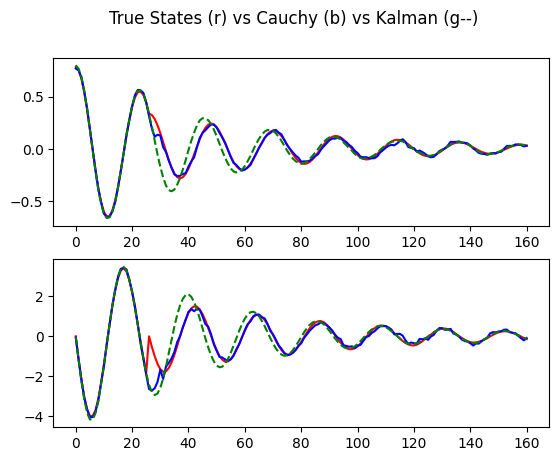

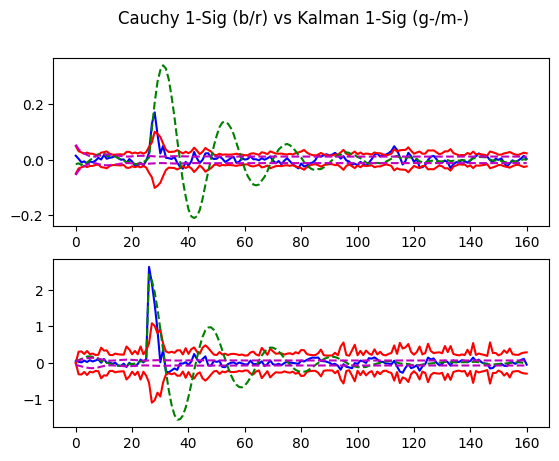

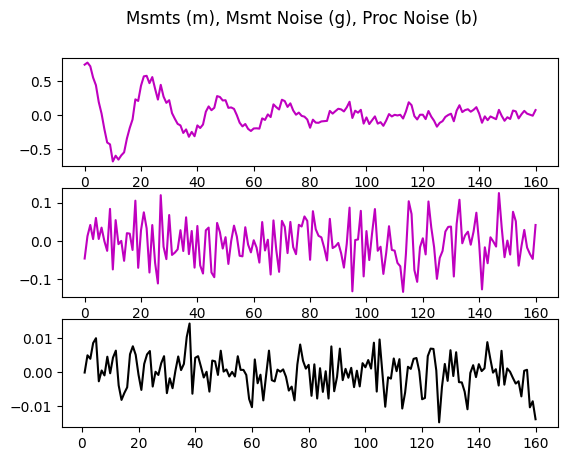

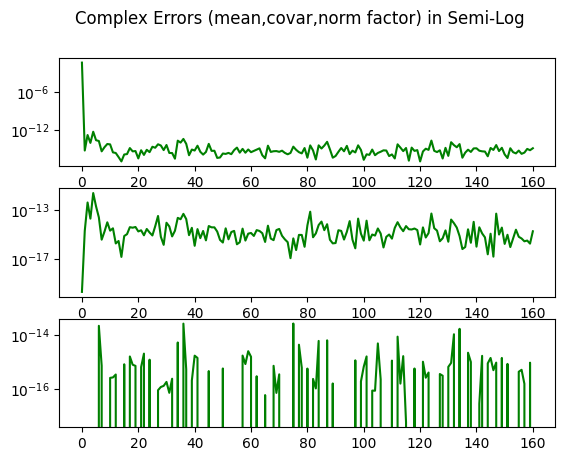

In [30]:
# Creating the dynamic simulation
xk = theta_vec0.copy()
xs = [xk] # State vector history
ws = []   # Process noise history
vs = [V[0]**0.5 * np.random.randn()] # Measurement noise history
zs = [H @ xk + vs[0]] # Measurement history
propagations = 160
for k in range(propagations):
    wk = pend.dt * pend.w_PSD**0.5 * np.random.randn(1)
    xk[1] += wk
    xk = nonlin_transition_model(xk)
    if k == 25:
        xk[1] = 0 # all of a sudden, the squeaky hinge catches, and velocity is sent to zero
    xs.append(xk)
    ws.append(wk)
    vk = V[0]**0.5 * np.random.randn(1)
    zk = H @ xk + vk
    vs.append(vk)
    zs.append(zk)
xs = np.array(xs)
zs = np.array(zs)
ws = np.array(ws)
vs = np.array(vs)

# Setting up and running the EKF
x0_kf = np.random.multivariate_normal(theta_vec0, P0_kf) # lets initialize the Kalman filter slightly off from the true state position

xs_kf = [x0_kf.copy()] 
Ps_kf = [P0_kf.copy()] 
x_kf = x0_kf.copy()
P_kf = P0_kf.copy() 
for k in range(propagations):
    Jac_F = jacobian_pendulum_ode(x_kf)
    Phi_k, W_k = ce.discretize_nl_sys(Jac_F, Gamma_c, W_c, pend.dt, taylor_order, with_Gamk = False, with_Wk = True)
    # Propagate covariance and state estimates
    P_kf = Phi_k @ P_kf @ Phi_k.T + W_k
    x_kf = nonlin_transition_model(x_kf)
    # Form Kalman Gain, update estimate and covariance
    K = P_kf @ H.T @ np.linalg.inv(H @ P_kf @ H.T + V)
    zbar = H @ x_kf
    r = zs[k+1] - zbar
    x_kf += K @ r 
    P_kf = (I2 - K @ H) @ P_kf @ (I2 - K @ H).T + K @ V @ K.T
    # Store estimates
    xs_kf.append(x_kf.copy())
    Ps_kf.append(P_kf.copy())
xs_kf = np.array(xs_kf)
Ps_kf = np.array(Ps_kf)

# Run the Cauchy Estimator
x0_ce = x0_kf.copy()
swm_print_debug = False 
win_print_debug = False
num_windows = 6
cauchyEst = ce.PySlidingWindowManager("nonlin", num_windows, swm_print_debug, win_print_debug)
cauchyEst.initialize_nonlin(x0_ce, A0, p0, b0, beta, gamma, dynamics_update, nonlinear_msmt_model, msmt_model_jacobian, num_controls, pend.dt)
for zk in zs:
    cauchyEst.step(zk, None)
cauchyEst.shutdown()

# Plot the results
ce.plot_simulation_history( cauchyEst.moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf) )
#ce.plot_simulation_history( cauchyEst.avg_moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf) )

Amazing, right? A little extra credit for you would be to go ahead and begin tracking/plotting what the CPDFs (of each window) look like and how they birfurcate when the sudden velocity change occurs. The proof is in the pudding though, the Cauchy Estimator is quite a magician in how good it is when things go bad.

Some comments to end this tutorial:

*For LTV systems, you simply need to provide the dynamics_update() callback as shown above. The other two are only for nonlinear estimation. Within it, you can update/use whatever combination of $\{x_k,u_k,\Phi_k,B_k,\Gamma_k,H_k,\gamma_k,\beta_k\}$ you'd like for the estimation step. This is the only difference between the LTI and LTV mode. 

*As fantastic as the Cauchy Estimator is (and it is fantastic), the number of process noises you model your system with has a big impact on the amount of memory the estimator will eventually consume (and therefore its execution rate). Furthermore, the more measurements you process, the more memory you'll consume as well. A rule of thumb is that with larger state dimensions, or more than one process noise / measurement per estimation step, the smaller you'll have to make the number of windows in the PySlidingWindowManager in order to keep a reasonable real time rate. The flip side to this comment is that generally, estimates conditioned on the last four time steps (four windows) works perfectly well. 

*If there exists states in your state space with very poor observability (i.e, the condition number of the Grammian, or emprical Grammian for nonlinear system is very large), the Cauchy Estimator may send the covariance of these states to the moon. And it makes some sense why: we are modelling the process noise as Cauchy, and therefore if this heavy-tailed noise affects a poorly observable state in a big way, the Cauchy Estimator will tell you it could really be anywhere, and its covariance will reflect just that. 

In the next tutorial, some of the advanced features of the estimator are discussed, and in which corner cases will they be useful.